<a href="https://colab.research.google.com/github/AdiY2j/CS6910_Assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install wandb

In [35]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)
from keras.datasets import fashion_mnist

In [36]:
wandb.login(key='72a114321dd97dbf11db7b15eb05b2660c2faa94')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [37]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [38]:
X_train.shape[0]

60000

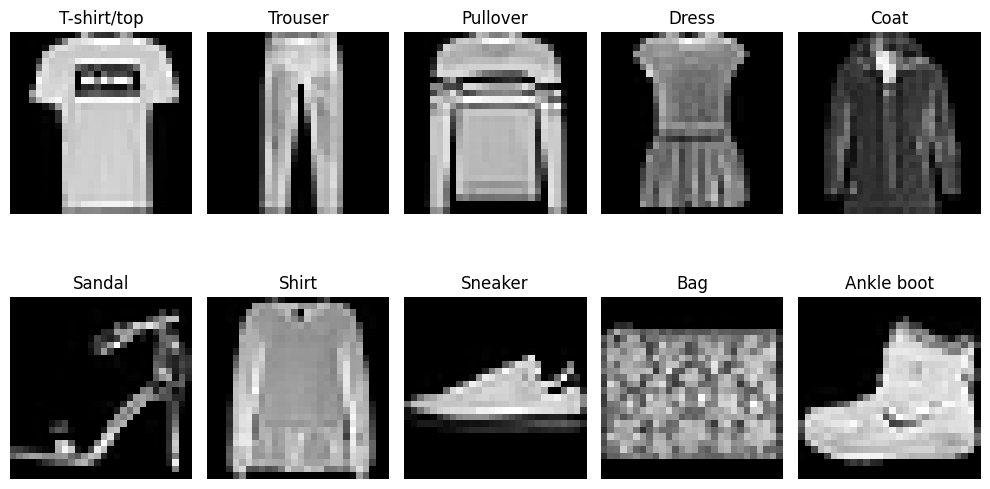

In [39]:
#wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

images = []
labels = []
# Function to plot one sample image for each class
def plot_data(x, y, class_labels):
    plt.figure(figsize=(10, 6))

    for i in range(len(class_labels)):
        id = np.where(y == i)[0][0]
        image = x[id]
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(class_labels[i])
        images.append(image)
        labels.append(class_labels[i])

    plt.tight_layout()
    plt.show()

plot_data(X_train, y_train, class_labels)
# wandb.log({"Question 1 " : [wandb.Image(image , caption = f"Label: {label}") for image, label in zip(images, labels)]})
# wandb.finish()

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [41]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# Reshape input feature from 28*28 to 784*1
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [42]:
X_train.shape

(54000, 784)

In [43]:
X_val.shape

(6000, 784)

In [44]:
def initializeParam(layers, activation, weight_init = "random"):
  params = {}
  for i in range(1, len(layers)):
    if weight_init == "Xavier" or activation == "relu":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1]) * np.sqrt(2/float(layers[i-1]))
    elif weight_init == "random":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1])

    params['b' + str(i)] = np.zeros((layers[i], 1))
  return params

In [45]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def sigmoid_dev(x):
  return x * (1 - x)

def relu_dev(x):
  return np.where(x > 0, 1, 0)

def tanh_dev(x):
  return 1 - x**2

def softmax(x):
  x = np.clip(x, -700, 700)
  return np.exp(x) / np.sum(np.exp(x), axis = 0)

In [46]:
def forward_prop(X, layers, params, activation):
  func = {}
  func['h0'] = X
  func['a0'] = X
  output = []
  for i in range(1, len(layers)):
    a = np.dot(params['W' + str(i)], func['h' + str(i-1)].T) + params['b' + str(i)]

    #print(params['W' + str(i)].shape, func['h' + str(i-1)].T.shape, params['b' + str(i)].shape, a.shape)

    if(i == len(layers) - 1) :
      h = softmax(a)
      output = h
    else :
      if activation == "sigmoid" :
        h = sigmoid(a)
      elif activation == "relu" :
        h = relu(a)
      elif activation == "tanh" :
        h = tanh(a)

    func['a' + str(i)] = a.T
    func['h' + str(i)] = h.T

  return output, func

In [47]:
def back_prop(func, params, y, pred_y, L, loss_func, activation):
  m = y.size
  gradients = {}
  dL_a = pred_y - y.T
  h_prev = func['h'+str(L)]
  act_dev = sigmoid_dev

  if activation == "sigmoid":
    act_dev = sigmoid_dev
  elif activation == "relu":
    act_dev = relu_dev
  elif activation == "tanh":
    act_dev = tanh_dev

  for k in range(L, -1, -1):
    dL_W = np.dot(dL_a, h_prev)
    dL_b = np.sum(dL_a, axis=1, keepdims=True)

    #print(dL_W.shape, dL_b.shape)

    dL_h = np.dot(params['W'+str(k+1)].T,  dL_a)
    dL_a = dL_h * act_dev(h_prev).T  #sigmoid (h_prev * (1- h_prev)).T

    gradients['dW' + str(k+1)] = dL_W
    gradients['db' + str(k+1)] = dL_b
    if(k-1 > -1):
      h_prev = func['h' + str(k-1)]


  return gradients

In [48]:
def sgd(params, gradients, eta, L, decay):
  for i in range(1, L):
    params['W' + str(i)] -=  eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    params['b' + str(i)] -=  eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

In [49]:
def mgd(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    history[key] = momentum * history[key] + eta * (gradients['d' + key] + decay * params[key])
    params[key] -= history[key]


In [50]:
def nag(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for i in range(1, L):
    history['W' + str(i)] = momentum * history['W' + str(i)] + eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    history['b' + str(i)] = momentum * history['b' + str(i)] + eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

    params['W' + str(i)] -= history['W' + str(i)]
    params['b' + str(i)] -= history['b' + str(i)]

In [51]:
def rmsprop(params, gradients, history, max_epochs, beta, eta, eps, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])

  for i in range(1, L):
    history['W' + str(i)] = beta * history['W' + str(i)] + (1 - beta) * gradients['dW' + str(i)]**2
    history['b' + str(i)] = beta * history['b' + str(i)] + (1 - beta) * gradients['db' + str(i)]**2

    params['W' + str(i)] -= (eta * gradients['dW' + str(i)]/(np.sqrt(history['W' + str(i)]) + eps)) + (eta * decay * params['W' + str(i)])
    params['b' + str(i)] -= (eta * gradients['db' + str(i)]/(np.sqrt(history['b' + str(i)]) + eps)) + (eta * decay * params['b' + str(i)])

In [52]:
def adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= eta * m_w_hat/(np.sqrt(v_w_hat) + eps) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= eta * m_b_hat/(np.sqrt(v_b_hat) + eps) + (eta * decay * params['b' + str(i)])


In [53]:
def nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= (eta/np.sqrt(v_w_hat + eps)) * (beta1 * m_w_hat + (1-beta1) * gradients['dW'+str(i)] / (1 - beta1**t)) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= (eta/np.sqrt(v_b_hat + eps)) * (beta1 * m_b_hat + (1-beta1) * gradients['db'+str(i)] / (1 - beta1**t)) + (eta * decay * params['b' + str(i)])

In [54]:
def compute_loss(y, y_pred, loss, epsilon=1e-10):
  if loss == "squared_loss":
    return np.sum((y - y_pred)**2)/y.shape[0]
  elif loss == "cross_entropy":
    return -np.sum(np.multiply(y, np.log(y_pred + epsilon)))/y.shape[0]

In [55]:
def loss_dev(y, y_pred, loss):
  if loss == "cross_entropy":
    return -y/y_pred
  elif loss == "squared_loss":
    return y_pred - y

In [56]:
def get_prediction(output):
  return np.argmax(output, axis=0)

def get_accuracy(prediction, Y):
  #print(prediction, Y)
  return np.sum(prediction == Y)/Y.size

def cal_confusion(prediction, Y):
  count = 0
  confusion_mat = np.zeros((10, 10))
  for i in range(len(prediction)):
    confusion_mat[prediction[i]][Y[i]] += 1
  print(confusion_mat)

In [57]:
def lookahead(params, history, momentum):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    else :
      history[key] = momentum * history[key]
    params[key] -= history[key]

In [58]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        },
        'batch_size' : {
            'values' : [16, 32, 64]
        },
        'learning_rate': {
            'values' : [1e-3, 5e-3, 1e-4]
        },
        'hidden_layers' : {
            'values' : [3, 4, 5]
        },
        'hidden_layer_size' :  {
            'values' : [32, 64, 128]
        },
        'weight_init' : {
            'values' : ['random', 'Xavier']
        },
        'weight_decay' : {
            'values' : [0, 0.005]
        },
        'optimizer' : {
            'values' : ['adam', 'nadam']
        },
        'activation' : {
            'values' : ['sigmoid', 'relu', 'tanh']
        }
    }
}

In [60]:
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_1', entity = "cs23m009")

Create sweep with ID: 1n1jt35c
Sweep URL: https://wandb.ai/cs23m009/DL_Assignment_1/sweeps/1n1jt35c


In [61]:
def main():
  with wandb.init() as run:
    run_name = 'o_{}_a_{}_lr_{}_hl{}_bs{}_w_{}'.format(wandb.config.optimizer, wandb.config.activation, wandb.config.learning_rate, str(wandb.config.hidden_layer_size) + "_" + str(wandb.config.hidden_layers), wandb.config.batch_size, wandb.config.weight_init)
    wandb.run.name = run_name
    train()

wandb.agent(sweep_id, function = main, count = 10)
wandb.finish()

wandb: Agent Starting Run: hk374glq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Train Loss: 3.025643434348525, Train Accuracy: 0.17874074074074073, Val Loss: 3.007659642833462, Val Accuracy: 0.17833333333333334
Epoch 2, Train Loss: 2.628281038145703, Train Accuracy: 0.19290740740740742, Val Loss: 2.6127077105647514, Val Accuracy: 0.19416666666666665
Epoch 3, Train Loss: 2.438635059226785, Train Accuracy: 0.24764814814814815, Val Loss: 2.4258366242474505, Val Accuracy: 0.2565
Epoch 4, Train Loss: 2.3035012090631555, Train Accuracy: 0.32425925925925925, Val Loss: 2.2945203904933527, Val Accuracy: 0.3275
Epoch 5, Train Loss: 2.187021705326917, Train Accuracy: 0.37466666666666665, Val Loss: 2.181404601687178, Val Accuracy: 0.37933333333333336
Epoch 6, Train Loss: 2.0804848659251296, Train Accuracy: 0.4260555555555556, Val Loss: 2.0769932339455415, Val Accuracy: 0.42916666666666664
Epoch 7, Train Loss: 1.9806853932791617, Train Accuracy: 0.46996296296296297, Val Loss: 1.978529608535011, Val Accuracy: 0.47583333333333333
Epoch 8, Train Loss: 1.887174087570907, 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▄▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▁▃▄▅▆▇▇██
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,0.5248
train_loss,1.71896
val_accuracy,0.52383
val_loss,1.72035


wandb: Agent Starting Run: 5qqls79p with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.39421085127503086, Train Accuracy: 0.8590185185185185, Val Loss: 0.40648828504929085, Val Accuracy: 0.8551666666666666
Epoch 2, Train Loss: 0.3535734507927465, Train Accuracy: 0.8722407407407408, Val Loss: 0.37198720876765523, Val Accuracy: 0.8631666666666666
Epoch 3, Train Loss: 0.3301353117718414, Train Accuracy: 0.8816851851851852, Val Loss: 0.35618341120824054, Val Accuracy: 0.869
Epoch 4, Train Loss: 0.3127896577169423, Train Accuracy: 0.8874074074074074, Val Loss: 0.3463553358265673, Val Accuracy: 0.8733333333333333
Epoch 5, Train Loss: 0.3018453952993495, Train Accuracy: 0.8911481481481481, Val Loss: 0.3414171764258092, Val Accuracy: 0.8766666666666667
Epoch 6, Train Loss: 0.2923716404637568, Train Accuracy: 0.8946481481481482, Val Loss: 0.33780890963276217, Val Accuracy: 0.8795
Epoch 7, Train Loss: 0.28439170087366433, Train Accuracy: 0.8977962962962963, Val Loss: 0.3343081856016978, Val Accuracy: 0.8806666666666667
Epoch 8, Train Loss: 0.2773655473717442

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.90365
train_loss,0.26537
val_accuracy,0.88267
val_loss,0.3304


wandb: Agent Starting Run: yr770upw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.7447579790602206, Train Accuracy: 0.7405925925925926, Val Loss: 0.7519228999857016, Val Accuracy: 0.7335
Epoch 2, Train Loss: 0.5671729661294432, Train Accuracy: 0.8135925925925926, Val Loss: 0.5730242102775558, Val Accuracy: 0.8105
Epoch 3, Train Loss: 0.4974742523104633, Train Accuracy: 0.832962962962963, Val Loss: 0.503039982102271, Val Accuracy: 0.8258333333333333
Epoch 4, Train Loss: 0.46158664271114397, Train Accuracy: 0.8415, Val Loss: 0.4672109229028387, Val Accuracy: 0.8356666666666667
Epoch 5, Train Loss: 0.4383959262721367, Train Accuracy: 0.8482777777777778, Val Loss: 0.4446970022180836, Val Accuracy: 0.8423333333333334


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▂▁
val_accuracy,▁▆▇██
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.84828
train_loss,0.4384
val_accuracy,0.84233
val_loss,0.4447


wandb: Agent Starting Run: tbx1y8ad with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.35028171759516663, Train Accuracy: 0.8743333333333333, Val Loss: 0.36151372853890756, Val Accuracy: 0.8678333333333333
Epoch 2, Train Loss: 0.3162648452895841, Train Accuracy: 0.884425925925926, Val Loss: 0.3397679650180386, Val Accuracy: 0.877
Epoch 3, Train Loss: 0.2928416793965215, Train Accuracy: 0.8928703703703704, Val Loss: 0.32695284171846667, Val Accuracy: 0.8823333333333333
Epoch 4, Train Loss: 0.27482428885724614, Train Accuracy: 0.8999814814814815, Val Loss: 0.3180480757073922, Val Accuracy: 0.8853333333333333
Epoch 5, Train Loss: 0.2611067405496824, Train Accuracy: 0.9045740740740741, Val Loss: 0.31248732649723004, Val Accuracy: 0.8875
Epoch 6, Train Loss: 0.24994349449995398, Train Accuracy: 0.9088888888888889, Val Loss: 0.309018287726093, Val Accuracy: 0.889
Epoch 7, Train Loss: 0.24036285432091137, Train Accuracy: 0.9121481481481482, Val Loss: 0.30692589229441636, Val Accuracy: 0.8906666666666667
Epoch 8, Train Loss: 0.23197503371704056, Train Accu

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.91965
train_loss,0.21761
val_accuracy,0.89183
val_loss,0.30525


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gplzyr4m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.35352396555816756, Train Accuracy: 0.8729629629629629, Val Loss: 0.3672055794985952, Val Accuracy: 0.8638333333333333
Epoch 2, Train Loss: 0.32185263035014255, Train Accuracy: 0.8818148148148148, Val Loss: 0.34647670810429104, Val Accuracy: 0.873
Epoch 3, Train Loss: 0.2968018712974001, Train Accuracy: 0.8908518518518519, Val Loss: 0.3319839151512537, Val Accuracy: 0.8776666666666667
Epoch 4, Train Loss: 0.2769053835068719, Train Accuracy: 0.8975, Val Loss: 0.32200806552033057, Val Accuracy: 0.8813333333333333
Epoch 5, Train Loss: 0.26224900288127445, Train Accuracy: 0.9028148148148148, Val Loss: 0.3166388283273173, Val Accuracy: 0.8828333333333334
Epoch 6, Train Loss: 0.25069885312205287, Train Accuracy: 0.906537037037037, Val Loss: 0.31373686234536513, Val Accuracy: 0.8845
Epoch 7, Train Loss: 0.24097333606391985, Train Accuracy: 0.9101481481481482, Val Loss: 0.31224497483272545, Val Accuracy: 0.887
Epoch 8, Train Loss: 0.23254625224518807, Train Accuracy: 0.91

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▄▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.91839
train_loss,0.21834
val_accuracy,0.88983
val_loss,0.3152


wandb: Agent Starting Run: 8vpn7c8j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4454875820792971, Train Accuracy: 0.8422037037037037, Val Loss: 0.45174930343518943, Val Accuracy: 0.8376666666666667
Epoch 2, Train Loss: 0.4062509955553442, Train Accuracy: 0.8565925925925926, Val Loss: 0.41468801912874953, Val Accuracy: 0.85
Epoch 3, Train Loss: 0.3851574108726086, Train Accuracy: 0.865037037037037, Val Loss: 0.3960658490482662, Val Accuracy: 0.856
Epoch 4, Train Loss: 0.3707072811787646, Train Accuracy: 0.8694074074074074, Val Loss: 0.3839536577557187, Val Accuracy: 0.8606666666666667
Epoch 5, Train Loss: 0.35965236210871565, Train Accuracy: 0.8730370370370371, Val Loss: 0.3751011378459829, Val Accuracy: 0.8633333333333333
Epoch 6, Train Loss: 0.3506282114182515, Train Accuracy: 0.8760925925925926, Val Loss: 0.36816932157943416, Val Accuracy: 0.865
Epoch 7, Train Loss: 0.34294329200273227, Train Accuracy: 0.878462962962963, Val Loss: 0.36248815242626825, Val Accuracy: 0.8675
Epoch 8, Train Loss: 0.3362037168044423, Train Accuracy: 0.880981481

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.8845
train_loss,0.32467
val_accuracy,0.87167
val_loss,0.34985


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7s4o3s40 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.350836406553602, Train Accuracy: 0.8721666666666666, Val Loss: 0.3639833051988629, Val Accuracy: 0.8673333333333333
Epoch 2, Train Loss: 0.3206417965559618, Train Accuracy: 0.8813888888888889, Val Loss: 0.34523762305650424, Val Accuracy: 0.8725
Epoch 3, Train Loss: 0.30120202638950455, Train Accuracy: 0.8892777777777777, Val Loss: 0.33744802581084765, Val Accuracy: 0.8766666666666667
Epoch 4, Train Loss: 0.28513927867221955, Train Accuracy: 0.8950370370370371, Val Loss: 0.3321787440632004, Val Accuracy: 0.8788333333333334
Epoch 5, Train Loss: 0.27122291960960887, Train Accuracy: 0.8994814814814814, Val Loss: 0.3279514383942856, Val Accuracy: 0.8816666666666667
Epoch 6, Train Loss: 0.25979304476907367, Train Accuracy: 0.9037222222222222, Val Loss: 0.32526106168985364, Val Accuracy: 0.8828333333333334
Epoch 7, Train Loss: 0.24997905901341455, Train Accuracy: 0.9068888888888889, Val Loss: 0.32382273579552073, Val Accuracy: 0.8838333333333334
Epoch 8, Train Loss: 0.2

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▅▃▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.91528
train_loss,0.22723
val_accuracy,0.88717
val_loss,0.32468


wandb: Agent Starting Run: g8uo0vqi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.34742700839438956, Train Accuracy: 0.8743703703703704, Val Loss: 0.363729329369011, Val Accuracy: 0.8663333333333333
Epoch 2, Train Loss: 0.31583847165814466, Train Accuracy: 0.8842222222222222, Val Loss: 0.3434413489136257, Val Accuracy: 0.8751666666666666
Epoch 3, Train Loss: 0.29388657033393634, Train Accuracy: 0.892425925925926, Val Loss: 0.33202901988046796, Val Accuracy: 0.8803333333333333
Epoch 4, Train Loss: 0.2775940150575553, Train Accuracy: 0.897962962962963, Val Loss: 0.3251040862250562, Val Accuracy: 0.8828333333333334
Epoch 5, Train Loss: 0.2643563447335725, Train Accuracy: 0.9027222222222222, Val Loss: 0.320399517978684, Val Accuracy: 0.8828333333333334
Epoch 6, Train Loss: 0.2527693485060952, Train Accuracy: 0.9066851851851851, Val Loss: 0.31678019260321455, Val Accuracy: 0.8838333333333334
Epoch 7, Train Loss: 0.24248125342117588, Train Accuracy: 0.9101481481481482, Val Loss: 0.3141229777586504, Val Accuracy: 0.8856666666666667
Epoch 8, Train Los

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▄▆▇▇▇██▇▇
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.91952
train_loss,0.21801
val_accuracy,0.88417
val_loss,0.3121


wandb: Agent Starting Run: i840d5zq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.35182197495232365, Train Accuracy: 0.8732407407407408, Val Loss: 0.3674077706303277, Val Accuracy: 0.8678333333333333
Epoch 2, Train Loss: 0.31769820634454915, Train Accuracy: 0.8845925925925926, Val Loss: 0.34441558992364857, Val Accuracy: 0.8713333333333333
Epoch 3, Train Loss: 0.2951026479291192, Train Accuracy: 0.8929074074074074, Val Loss: 0.3310277716255949, Val Accuracy: 0.8761666666666666
Epoch 4, Train Loss: 0.2792468441357405, Train Accuracy: 0.8983888888888889, Val Loss: 0.3234116365498804, Val Accuracy: 0.879
Epoch 5, Train Loss: 0.2667384864161168, Train Accuracy: 0.9028703703703703, Val Loss: 0.3184634484854522, Val Accuracy: 0.8816666666666667
Epoch 6, Train Loss: 0.2562513429263629, Train Accuracy: 0.9067037037037037, Val Loss: 0.31479323883432236, Val Accuracy: 0.8845
Epoch 7, Train Loss: 0.24706253538705036, Train Accuracy: 0.9100925925925926, Val Loss: 0.31189464043281867, Val Accuracy: 0.8846666666666667
Epoch 8, Train Loss: 0.2388160728305527

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▄▅▅▆▆▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.91783
train_loss,0.22428
val_accuracy,0.88983
val_loss,0.30635


wandb: Agent Starting Run: 91lxjdvc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.5111541393844905, Train Accuracy: 0.5938333333333333, Val Loss: 2.5977133970588007, Val Accuracy: 0.5838333333333333
Epoch 2, Train Loss: 1.8323498725767486, Train Accuracy: 0.6381111111111111, Val Loss: 1.8702929764884544, Val Accuracy: 0.6248333333333334
Epoch 3, Train Loss: 1.4637001867729602, Train Accuracy: 0.6529444444444444, Val Loss: 1.5606435605216917, Val Accuracy: 0.6386666666666667
Epoch 4, Train Loss: 1.2289078668081128, Train Accuracy: 0.6727777777777778, Val Loss: 1.3048553755069368, Val Accuracy: 0.6561666666666667
Epoch 5, Train Loss: 1.0747716200554973, Train Accuracy: 0.6870185185185185, Val Loss: 1.1946758874445222, Val Accuracy: 0.6633333333333333
Epoch 6, Train Loss: 0.9739311388845335, Train Accuracy: 0.7056851851851852, Val Loss: 1.1023490644407874, Val Accuracy: 0.6736666666666666
Epoch 7, Train Loss: 0.8858698975546414, Train Accuracy: 0.719037037037037, Val Loss: 1.0264648287153955, Val Accuracy: 0.6878333333333333
Epoch 8, Train Loss: 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▅▆▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.74989
train_loss,0.73228
val_accuracy,0.71017
val_loss,0.89951


In [59]:
def train():
  input_neurons = X_train.shape[1]
  hidden_neurons = wandb.config["hidden_layer_size"] #[16]
  num_layers = wandb.config["hidden_layers"] #3
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  #print(layers)
  y_train_onehot = np.eye(10)[y_train]
  y_val_onehot = np.eye(10)[y_val]
  loss_function = "cross_entropy"
  activation = wandb.config["activation"] #"sigmoid"
  weight_init = wandb.config["weight_init"] #"random"

  params = initializeParam(layers, activation, weight_init)
  eta = wandb.config["learning_rate"] #1e-3
  max_epochs = wandb.config["epochs"] #10
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= wandb.config["batch_size"] #32
  optimizer = wandb.config["optimizer"] #"sgd"
  decay = wandb.config["weight_decay"]
  final_res = []
  history = {}
  moment = {}

  for epoch in range(max_epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_train[i : i + batch_size]
      y_batch = y_train_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

    y_predict, func = forward_prop(X_train, layers, params, activation)
    train_loss = compute_loss(y_train_onehot, y_predict.T, loss_function)
    train_accuracy = get_accuracy(get_prediction(y_predict), y_train)

    y_val_predict, _ = forward_prop(X_val, layers, params, activation)
    val_loss = compute_loss(y_val_onehot, y_val_predict.T, loss_function)
    val_accuracy = get_accuracy(get_prediction(y_val_predict), y_val)

    #final_res = get_prediction(y_predict)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss' : val_loss, 'val_accuracy' : val_accuracy, 'epoch': epoch+1})

In [32]:
def confusion_matrix(X_test, y_test, hidden_layer_size, hidden_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch, opt_func, wt_decay):
  wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
  input_neurons = X_test.shape[1]
  hidden_neurons = hidden_layer_size
  num_layers = hidden_layers
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_test_onehot = np.eye(10)[y_test]
  loss_function = loss_func
  activation = activation_func
  weight_init = wt_init


  params = initializeParam(layers, activation, weight_init)
  eta = learning_rate
  max_epochs = epochs
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch
  optimizer = opt_func
  decay = wt_decay
  final_res = []
  history = {}
  moment = {}
  print(layers)

  for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_test[i : i + batch_size]
      y_batch = y_test_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

  y_predict, func = forward_prop(X_test, layers, params, activation)
  test_loss = compute_loss(y_test_onehot, y_predict.T, loss_function)
  test_accuracy = get_accuracy(get_prediction(y_predict), y_test)
  cal_confusion(get_prediction(y_predict), y_test)
  wandb.log({"Confusion Matrix " : wandb.sklearn.plot_confusion_matrix(y_test, get_prediction(y_predict), class_labels)})
  print(test_accuracy, test_loss)
  wandb.finish()

In [33]:
confusion_matrix(X_test, y_test, 128, 3, "cross_entropy", "tanh", "Xavier", 0.001, 10, 64, "nadam", 0)

[784, 128, 128, 128, 10]
[[838.   2.  10.  34.   0.   0.  79.   0.   2.   0.]
 [  1. 981.   2.   8.   1.   0.   1.   0.   1.   0.]
 [  6.   0. 644.  10.  21.   0.  51.   0.   0.   0.]
 [  7.  12.   4. 814.   2.   0.   9.   0.   0.   0.]
 [  7.   4. 302.  84. 961.   0. 207.   0.   5.   0.]
 [  0.   0.   0.   1.   0. 994.   0.  39.   0.   5.]
 [131.   1.  33.  47.  14.   0. 641.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   5.   0. 935.   1.  27.]
 [ 10.   0.   5.   2.   1.   1.  12.   5. 991.   1.]
 [  0.   0.   0.   0.   0.   0.   0.  21.   0. 967.]]
0.8766 0.32944547957156234


In [89]:
confusion_matrix(X_test, y_test, 128, 5, "cross_entropy", "tanh", "Xavier", 0.001, 10, 64, "nadam", 0)

[784, 128, 128, 128, 128, 128, 10]
[[688.   2.   6.  10.   0.   0.  44.   0.   0.   0.]
 [  0. 979.   2.   6.   1.   0.   3.   0.   0.   0.]
 [  9.   0. 590.   1.  10.   0.  39.   0.   1.   0.]
 [  8.  15.   6. 857.   4.   0.   6.   0.   1.   0.]
 [  3.   3. 328.  68. 969.   0. 183.   0.   4.   0.]
 [  0.   0.   0.   0.   0. 997.   0.  36.   0.   3.]
 [283.   1.  65.  55.  16.   0. 717.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   1.   0. 945.   1.  30.]
 [  9.   0.   3.   3.   0.   0.   8.   3. 992.   1.]
 [  0.   0.   0.   0.   0.   2.   0.  16.   0. 966.]]
0.87 0.3321365156611811
